In [73]:
#-*-coding:utf-8-*-
import pandas as pd
import numpy as np
from pandas import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import tensorflow as tf
from datetime import timedelta
import autokeras as ak
from kerastuner import HyperModel
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from datetime import timedelta
import math
import keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import save_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from pickle import dump,load
import warnings
warnings.simplefilter("ignore", UserWarning)
# from hyperopt import Trials, STATUS_OK, tpe, fmin, hp

#만든 모듈을 불러옴
import sys
from importlib import reload
sys.path.append('C:/Users/USER/Documents/GitHub/Time_Series_models/Demand_predict/') 
print(sys.path)
import LSTM_module as tsm


['c:\\Users\\USER\\Documents\\GitHub\\Time_Series_models\\Demand_predict', 'c:\\Users\\USER\\AppData\\Local\\Programs\\Python\\Python39\\python39.zip', 'c:\\Users\\USER\\AppData\\Local\\Programs\\Python\\Python39\\DLLs', 'c:\\Users\\USER\\AppData\\Local\\Programs\\Python\\Python39\\lib', 'c:\\Users\\USER\\AppData\\Local\\Programs\\Python\\Python39', '', 'c:\\Users\\USER\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages', 'c:\\Users\\USER\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\win32', 'c:\\Users\\USER\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\win32\\lib', 'c:\\Users\\USER\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\Pythonwin', 'C:/Users/USER/Documents/GitHub/Time_Series_models/Demand_predict/', 'C:/Users/USER/Documents/GitHub/Time_Series_models/Demand_predict/']


C:\Users\USER\AppData\Local\Temp\ipykernel_24412\872417664.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [103]:
data=pd.read_excel('C:/Users/USER/Desktop/진행중/FEMS/datamart/무림페이퍼_15분사용전력_210401-220630.xlsx')
data.columns
data=data.drop(['등록시각'],axis=1)
data['기준시각']=pd.to_datetime(data['기준시각'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42766 entries, 0 to 42765
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   기준시각         42766 non-null  datetime64[ns]
 1   직전 15분 사용전력  42766 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 668.3 KB


In [104]:
#train_test split
def train_test_split(data_t,train_cut_date,val_cut_date): 
  
    df_train = data_t[data_t['기준시각'] < train_cut_date ]
    df_val= data_t[(data_t['기준시각'] >= train_cut_date ) & (data_t['기준시각'] < val_cut_date )]
    df_test = data_t[(data_t['기준시각'] >= val_cut_date)] 
    
    return (df_train,df_val,df_test) 

df_train,df_val,df_test=train_test_split(data,'2022-06-01','2022-06-30')
print('train_df=',min(df_train['기준시각']),'~',max(df_train['기준시각']),',',len(df_train))
print('val_df=',min(df_val['기준시각']),'~',max(df_val['기준시각']),',',len(df_val))
# print('test_df=',min(df_test['기준시각']),'~',max(df_test['기준시각']),',',len(df_test))

train_df= 2021-04-01 00:00:00 ~ 2022-05-31 23:45:00 , 39886
val_df= 2022-06-01 00:00:00 ~ 2022-06-29 23:45:00 , 2784


In [58]:
# dateaframe to tensor
nd=np.asarray(df_train['직전 15분 사용전력'])
ndd=nd.reshape(len(df_train),)

nv=np.asarray(df_val['직전 15분 사용전력'])
nvv=nv.reshape(len(df_val),)

nt=np.asarray(df_test['직전 15분 사용전력'])
ntt=nt.reshape(len(df_test),)

In [59]:
n_steps = 10
(train_x, train_y) = tsm.split_sequence(ndd, n_steps) 
print(train_x.shape) 
print(train_y.shape)
(val_x, val_y) = tsm.split_sequence(nvv, n_steps) 
print(val_x.shape) 
print(val_y.shape)
(test_x, test_y) = tsm.split_sequence(ntt, n_steps) 
print(test_x.shape) 
print(test_y.shape)

(39876, 10)
(39876,)
(2774, 10)
(2774,)
(86, 10)
(86,)


In [60]:
n_features = 1
train_x = train_x.reshape(train_x.shape[0], n_steps, n_features)
val_x = val_x.reshape(val_x.shape[0], n_steps, n_features)

print(train_x.shape)
print(val_x.shape) 

(39876, 10, 1)
(2774, 10, 1)


In [61]:
# train(train,val)
# Hyperparameter Setting
BATCH_SIZE = 32
BUFFER_SIZE=100

# # Dataset -> Tensor
train_univariate = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((val_x, val_y))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

### AutoArima

In [75]:
# data=data[data['직전 15분 사용전력']>7000]

In [ ]:
#시계열 모델을 위한 tsdata화

ts_data=data.set_index('기준시각')
ts_data

In [77]:
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller   #H0=안정적이지 않음(비정상시계열) / H1:안정적임(정상시계열)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [78]:
def decomposition_plot(ts):
    # Apply seasonal_decompose 
    decomposition = seasonal_decompose(ts)
    
    # Get trend, seasonality, and residuals
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plotting
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(np.log(ts), label='Original', color='blue')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')
    plt.tight_layout()

def stationarity_check(ts):
            
    # Calculate rolling statistics
    roll_mean = ts.rolling(window=8, center=False).mean()
    roll_std = ts.rolling(window=8, center=False).std()

    # Perform the Dickey Fuller test
    dftest = adfuller(ts) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results

    print('\nResults of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

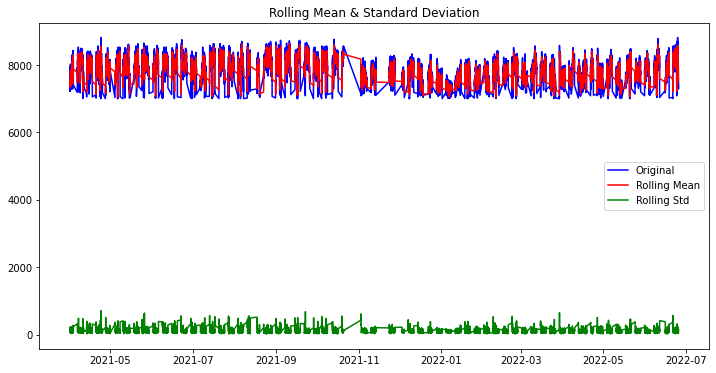


Results of Dickey-Fuller Test: 

Test Statistic                -1.627340e+01
p-value                        3.469746e-29
#Lags Used                     1.300000e+01
Number of Observations Used    2.290600e+04
Critical Value (1%)           -3.430636e+00
Critical Value (5%)           -2.861666e+00
Critical Value (10%)          -2.566837e+00
dtype: float64


In [79]:
stationarity_check(ts_data)

In [80]:
from pmdarima import model_selection
from sklearn.model_selection import TimeSeriesSplit
def TS_holdout(ts,testsize): #"testsize"= 예측을 원하는 개월 수(h)
    
    train, test = model_selection.train_test_split(ts, train_size=len(ts)-testsize)
    return train, test

In [89]:
train,test=TS_holdout(ts_data,30)
train

,직전 15분 사용전력
기준시각,
2021-04-01 00:00:00,7224.0
2021-04-01 00:15:00,7274.4
2021-04-01 00:30:00,7442.4
2021-04-01 00:45:00,7392.0
2021-04-01 01:00:00,7576.8
...,...
2022-06-25 06:45:00,7761.6
2022-06-25 07:00:00,7812.0
2022-06-25 07:15:00,7845.6


In [90]:
from pmdarima.arima import auto_arima
model= auto_arima(train, trace=True,suppress_warnings=True, start_p=0, start_q=0)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=284760.737, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=284761.004, Time=0.44 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=284759.913, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=284758.739, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=283817.805, Time=3.64 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=283370.540, Time=6.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=283881.183, Time=0.68 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=8.44 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=283316.734, Time=6.42 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=283318.230, Time=2.45 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=12.10 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=16.48 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=283314.311, Time=4.77 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=283415.353, Time=1.63 sec
 ARIMA(1,1,4)(0,0,0)[0] 

In [91]:
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                22890
Model:               SARIMAX(1, 1, 3)   Log Likelihood             -141651.153
Date:                Thu, 14 Jul 2022   AIC                         283312.306
Time:                        16:57:52   BIC                         283352.498
Sample:                             0   HQIC                        283325.370
                              - 22890                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6283      0.024     26.440      0.000       0.582       0.675
ma.L1         -0.6568      0.025    -26.395      0.000      -0.706      -0.608
ma.L2         -0.2040      0.006    -33.009      0.000      -0.216      -0.192
ma.L3          0.0445      0.010      4.303      0.000       0.024       0.065
sigma2      1.393e+04     68.348    203.841      0.000    1.38e+04    1.41e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             28579.99
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [93]:
w_predict=30
prediction=pd.DataFrame(model.predict(n_periods=w_predict))
prediction.columns=['predicted']
prediction.index=test.index

In [97]:
def predict_graph(test,prediction) : #train,
    plt.figure(figsize=(30,10))
    kws = dict(marker='o')
    # plt.plot(train, label='Train', **kws)   
    plt.plot(test, label='Test', **kws)   
    plt.plot(prediction,label='predicted', **kws)
    plt.legend()
    return plt.show()

In [98]:
test

,직전 15분 사용전력
기준시각,
2022-06-25 08:00:00,8047.2
2022-06-25 08:15:00,8064.0
2022-06-25 08:30:00,7980.0
2022-06-25 08:45:00,7744.8
2022-06-25 09:00:00,7862.4
2022-06-25 09:15:00,7828.8
2022-06-25 09:30:00,8064.0
2022-06-25 09:45:00,8114.4
2022-06-25 10:00:00,8080.8


In [99]:
prediction

,predicted
기준시각,
2022-06-25 08:00:00,7990.840796
2022-06-25 08:15:00,7997.837021
2022-06-25 08:30:00,8000.978441
2022-06-25 08:45:00,8002.952341
2022-06-25 09:00:00,8004.192634
2022-06-25 09:15:00,8004.971967
2022-06-25 09:30:00,8005.461659
2022-06-25 09:45:00,8005.769355
2022-06-25 10:00:00,8005.962695


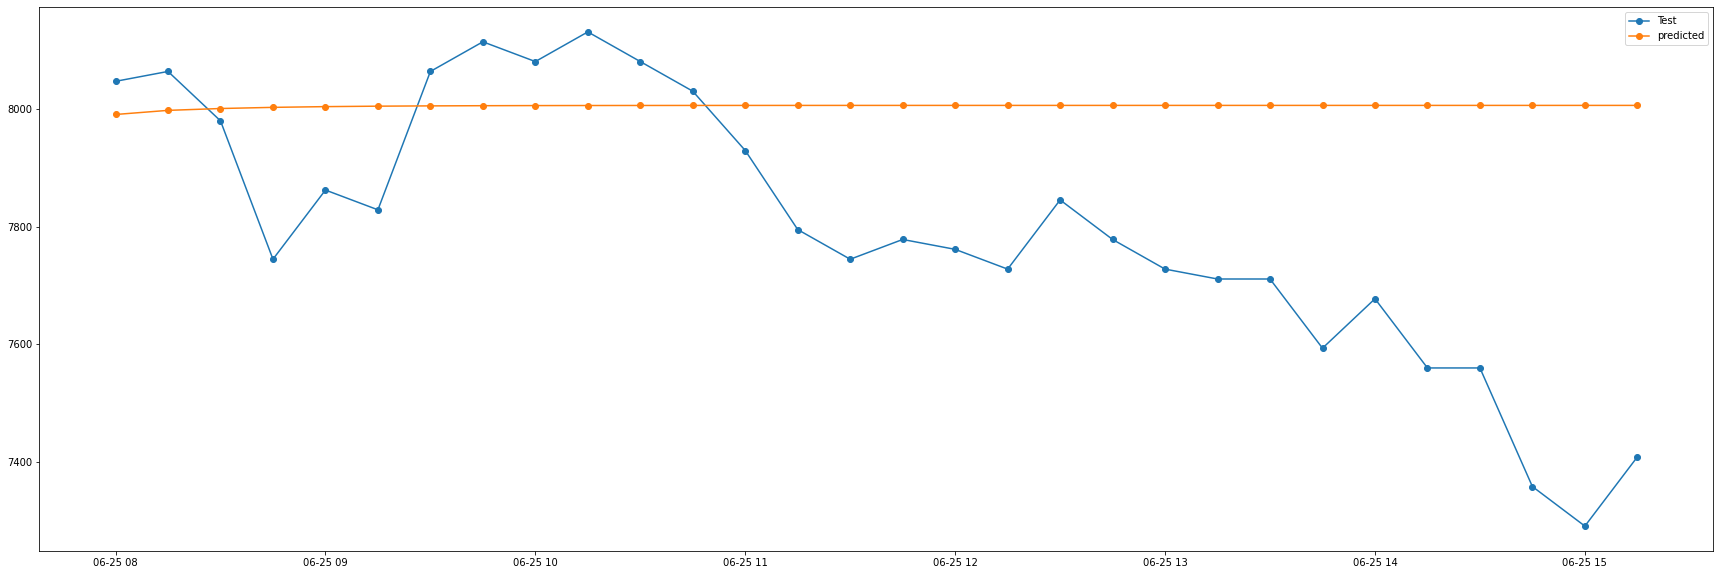

In [100]:
#graph
predict_graph(test,prediction)

###  Autokeras

In [65]:
import tensorflow as tf
import autokeras as ak

In [97]:
predict_from = 30
predict_until = 10
lookback = 3
clf = ak.TimeseriesForecaster(
    lookback=lookback,
    predict_from=predict_from,
    predict_until=predict_until,
    max_trials=1,
    objective="val_loss",
)
# Train the TimeSeriesForecaster with train data
model=clf.fit(
    x=train_x,
    y=train_y,
    validation_data=(val_x, val_y),
    batch_size=32,
    epochs=10,
)


INFO:tensorflow:Reloading Oracle from existing project .\time_series_forecaster\oracle.json


INFO:tensorflow:Reloading Oracle from existing project .\time_series_forecaster\oracle.json


INFO:tensorflow:Reloading Tuner from .\time_series_forecaster\tuner0.json


INFO:tensorflow:Reloading Tuner from .\time_series_forecaster\tuner0.json


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/10
1247/1247 [==============================] - 11s 7ms/step - loss: 48796276.0000 - mean_squared_error: 48796276.0000 - val_loss: 47664604.0000 - val_mean_squared_error: 47664604.0000
Epoch 2/10
1247/1247 [==============================] - 7s 6ms/step - loss: 48416108.0000 - mean_squared_error: 48416108.0000 - val_loss: 47314188.0000 - val_mean_squared_error: 47314188.0000
Epoch 3/10
1247/1247 [==============================] - 7s 6ms/step - loss: 48068628.0000 - mean_squared_error: 48068628.0000 - val_loss: 46970412.0000 - val_mean_squared_error: 46970412.0000
Epoch 4/10
1247/1247 [==============================] - 7s 6ms/step - loss: 47721208.0000 - mean_squared_error: 47721208.0000 - val_loss: 46628528.0000 - val_mean_squared_error: 46628528.0000
Epoch 5/10
1247/1247 [==============================] - 7s 6ms/step - loss: 47379200.0000 - mean_squared_error: 47379200.0000 - val_loss: 46288756.0000 - val_mean_squared_error: 46288756.0000
Epoch 6/10
1247/1247 [=================

INFO:tensorflow:Assets written to: .\time_series_forecaster\best_model\assets


INFO:tensorflow:Assets written to: .\time_series_forecaster\best_model\assets


In [101]:
# Predict with the best model(includes original training data).
predictions = clf.predict(train_x)
print(predictions.shape)
# Evaluate the best model with testing data.
print(clf.evaluate(test_x, test_y))

1247/1247 [==============================] - 7s 5ms/step
(0, 1)
3/3 [==============================] - 1s 12ms/step - loss: 32334866.0000 - mean_squared_error: 32334866.0000
[32334866.0, 32334866.0]


### Prophet(pytorch)

In [109]:
data=data[['기준시각','직전 15분 사용전력']]
data['기준시각']=pd.to_datetime(data['기준시각'])

### LSTM

In [62]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.models import load_model

In [63]:
path_checkpoint = "lstm_model_checkpoint_try4.h5"
es_callback = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=0, patience=100, mode='auto')# mode=auto loss면 최저값100번정도 반복되면 정지, acc면 최고값이 100번정도 반복되면 정지

modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor="loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,)

In [64]:
# Build Simple LSTM Model
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(10, activation = 'relu', input_shape=(n_steps,1),return_sequences=True),#
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(20, activation = 'relu', input_shape=(n_steps,1),return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(10, activation = 'relu', input_shape=(n_steps,1)), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5),   
    tf.keras.layers.Dense(1)
])


simple_lstm_model.compile(optimizer='adam', loss='mse',metrics=['mse'])

In [66]:
# Train the Model(val)
EVALUATION_INTERVAL = 100
EPOCHS = 1000

history=simple_lstm_model.fit(train_univariate , epochs=EPOCHS,validation_data=val_univariate,steps_per_epoch=EVALUATION_INTERVAL,validation_steps=1,verbose=1,callbacks=[es_callback, modelckpt_callback])

Epoch 1/1000
 99/100 [============================>.] - ETA: 0s - loss: 41663796.0000 - mse: 41663796.0000
Epoch 1: loss improved from inf to 41495100.00000, saving model to lstm_model_checkpoint_try4.h5
100/100 [==============================] - 3s 10ms/step - loss: 41495100.0000 - mse: 41495100.0000 - val_loss: 12922754.0000 - val_mse: 12922754.0000
Epoch 2/1000
100/100 [==============================] - ETA: 0s - loss: 17689754.0000 - mse: 17689754.0000
Epoch 2: loss improved from 41495100.00000 to 17689754.00000, saving model to lstm_model_checkpoint_try4.h5
100/100 [==============================] - 1s 7ms/step - loss: 17689754.0000 - mse: 17689754.0000 - val_loss: 3362504.2500 - val_mse: 3362504.2500
Epoch 3/1000
 95/100 [===========================>..] - ETA: 0s - loss: 14472637.0000 - mse: 14472637.0000
Epoch 3: loss improved from 17689754.00000 to 14281874.00000, saving model to lstm_model_checkpoint_try4.h5
100/100 [==============================] - 1s 7ms/step - loss: 142818

kerastuner_model


In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32),return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(Y_train.shape[1], activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    return model

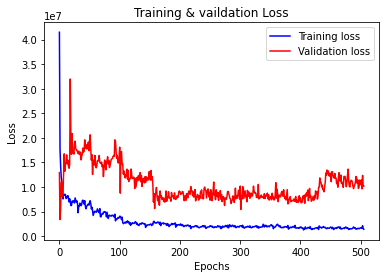

In [67]:
tsm.visualize_loss(history, "Training & vaildation Loss",'C:/Users/USER/Desktop/진행중/FEMS/moorim/')

In [71]:
yhat = simple_lstm_model.predict(test_x)
prediction=pd.DataFrame(yhat)
prediction.columns=['yhat']
# prediction.index=df_test[4:].index   # index 설정방법
df_test=df_test.reset_index()
prediction=prediction.reset_index()
prediction['y']=df_test['직전 15분 사용전력']
prediction['time']=df_test['기준시각']
prediction



3/3 [==============================] - 0s 2ms/step


,index,yhat,y,time
0,0,3577.253662,5846.4,2022-06-30 00:00:00
1,1,3594.415039,5812.8,2022-06-30 00:15:00
2,2,3608.278320,5745.6,2022-06-30 00:30:00
3,3,3625.884033,5712.0,2022-06-30 00:45:00
4,4,3645.950195,5745.6,2022-06-30 01:00:00
...,...,...,...,...
81,81,3455.373047,5796.0,2022-06-30 20:15:00
82,82,3445.464844,5812.8,2022-06-30 20:30:00
83,83,3432.260742,5661.6,2022-06-30 20:45:00
84,84,3418.930176,5796.0,2022-06-30 21:00:00


In [72]:
plt.figure(figsize=(30,20))
kws = dict(marker='o')
plt.plot(train['기준시각'],train['직전 15분 사용전력'], label='Train', **kws)   
plt.plot(test['기준시각'],test['직전 15분 사용전력'], label='Test', **kws)   
plt.plot(prediction['time'],prediction['yhat'],label='predicted', **kws)
plt.legend()
plt.show()

KeyError: '기준시각'

<Figure size 2160x1440 with 0 Axes>

In [ ]:
from kerastuner.tuners import BayesianOptimization